This notebook shows an example of SUSHI being used to unmix the components of the toymodel described in Lascar, Acero, Bobin 2023. 

In [1]:
# Imports 
%matplotlib inline

#autorealod library when an external lib is changed. 
import sys, os
%load_ext autoreload  
%autoreload 2
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from ipywidgets import interact, fixed
import numba #not mandatory, but without numba, the wavelet transform is much slower.
from Sushi import SUSHI
import jax
if int(jax.__version__[2])<4:
    import IAE_JAX_v2_devl_2022 as mld
else:
    import IAE_JAX_v2_devl_2023 as mld


Numba imported


# Loading the toymodel

In [2]:
with open("data/toymodel_data.p","rb") as f:
    DATA=pickle.load(f)
with open("data/toymodel_ground_truth.p","rb") as f:
    GT=pickle.load(f)

In [3]:
def show_data_cube(i,j,param):
    #i,j: pixel position
    #param: parameter to show the ground truth of. 
    #    kT: temperature. z: velocity redshift. 
    #    pho: photon index (synchrotron component)
    E=GT["channels"]
    fig,ax=plt.subplots(1,2,figsize=(11,4),gridspec_kw={'width_ratios': [3, 2]})
    ax[0].plot(E,DATA[:,i,j],alpha=0.5,label="data")
    ax[0].plot(E,GT["Total"][:,i,j],"k--")
    ax[0].plot(E,GT["Thermal"][:,i,j],"r--")
    ax[0].plot(E,GT["Synch"][:,i,j],"g--")
    pcm=ax[1].imshow(GT["Params"][param])
    ax[1].scatter(j,i,c="r",marker="+")
    fig.colorbar(pcm,ax=ax[1],shrink=0.8)
interact(show_data_cube,i=(0,93,1),j=(0,93,1),param=["kT","z","pho"])

interactive(children=(IntSlider(value=46, description='i', max=93), IntSlider(value=46, description='j', max=9…

<function __main__.show_data_cube(i, j, param)>

# Importing the trained IAE models

In [4]:
if int(jax.__version__[2])<4:
    #old version of Jax
    model_name="IAE_models/IAE_thermal_abdapec_kT_z_3keV-8keV_4AP"
    model = mld.load_model(model_name)
    IAE_Thermal = mld.IAE(Model = model)
    
    model_name="IAE_models/IAE_synchrotron_powerlaw_pho_3keV-8keV_2AP"
    model= mld.load_model(model_name)
    IAE_Synch= mld.IAE(Model = model)
    
else:
    #From version 0.4 on 
    model_name="IAE_models/IAE_thermal_abdapec_kT_z_3keV-8keV_4AP_jax_numpy.npy"
    model = np.load(model_name,allow_pickle=True).item()
    IAE_Thermal = mld.IAE(Model = model)
    
    model_name="IAE_models/IAE_synchrotron_powerlaw_pho_3keV-8keV_2AP_jax_numpy.npy"
    model= np.load(model_name,allow_pickle=True).item()
    IAE_Synch= mld.IAE(Model = model)



# Using SUSHI 

In [ ]:
res_toymodel=SUSHI(DATA,self_T=IAE_Thermal,self_S=IAE_Synch,
                              Amplitude_S=None,Amp_fixed=False,Amplitude_T=None,
                           niter=10000,stop=1e-7,J=2,kmad=1,mask_amp=10,background=None,
                  Cost_function="Poisson",Chi_2_sigma=None,Custom_Cost=None)

#To save the results in a pickle file, uncomment these lines: 

#with open("res_sushi_toymodel.p","wb") as f:
#    pickle.dump(res_toymodel,f)

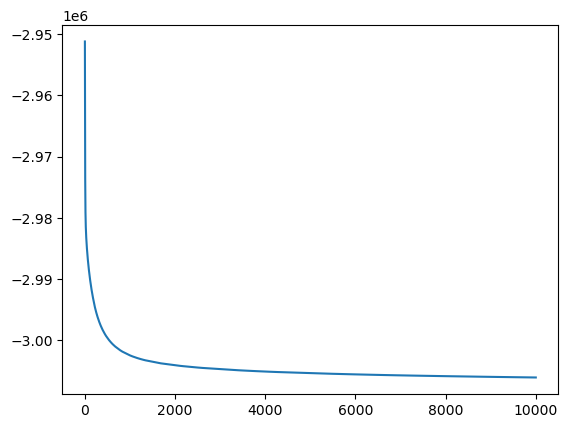

In [10]:
plt.plot(res_toymodel['Likelihood'])

In [11]:
def show_data_cube(i,j,param):
    #i,j: pixel position
    #param: parameter to show the ground truth of. 
    #    kT: temperature. z: velocity redshift. 
    #    pho: photon index (synchrotron component)
    
    E=GT["channels"]
    fig,ax=plt.subplots(1,2,figsize=(11,4),gridspec_kw={'width_ratios': [3, 2]})
    ax[0].plot(E,DATA[:,i,j],alpha=0.5,label="data")
    ax[0].plot(E,GT["Total"][:,i,j],"k--")
    ax[0].plot(E,GT["Thermal"][:,i,j],"r--")
    ax[0].plot(E,GT["Synch"][:,i,j],"g--")
    
    XRec_total=np.reshape(res_toymodel["XRec"]["Total"].T,DATA.shape)
    ax[0].plot(E,XRec_total[:,i,j],"k")
    XRec_thermal=np.reshape(res_toymodel["XRec"]["Total"].T,DATA.shape)
    ax[0].plot(E,XRec_thermal[:,i,j],"r")
    XRec_synch=np.reshape(res_toymodel["XRec"]["Total"].T,DATA.shape)
    ax[0].plot(E,XRec_synch[:,i,j],"g")
    
    pcm=ax[1].imshow(GT["Params"][param])
    ax[1].scatter(j,i,c="r",marker="+")
    fig.colorbar(pcm,ax=ax[1],shrink=0.8)
interact(show_data_cube,i=(0,93,1),j=(0,93,1),param=["kT","z","pho"])

interactive(children=(IntSlider(value=46, description='i', max=93), IntSlider(value=46, description='j', max=9…

<function __main__.show_data_cube(i, j, param)>

To obtain the physical parameters from this fit, at this point is to perform a 1D fit on the unmixed pixels obtained by SUSHI. A method that integrates this to SUSHI directly is in the works. 